# ДОМАШНЕЕ ЗАДАНИЕ: КЛАССИФИКАЦИЯ СЕРДЕЧНЫХ ЗАБОЛЕВАНИЙ
### Формулировка задачи
* Датасет: scikit-learn/auto-mpg
* https://huggingface.co/datasets/scikit-learn/auto-mpg

### Описание:

* 398 записей об автомобилях.
* Признаки: mpg, cylinders, displacement, horsepower, weight,acceleration, model year, origin, car name
* Целевая переменная: числовая переменная mpg (расход топлива автомобиля).
### Задача:
По описанию автомобиля предсказать его расход топлива.

* Тип задачи: регрессия (предсказываем число).
* Метрики: MAE, RMSE, R², RMSLE

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.dummy import DummyRegressor
import scipy.stats as stats

# Настройка отображения графиков
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('seaborn-v0_8')

Размерность данных: (398, 9)

Первые 5 строк:
    mpg  cylinders  displacement horsepower  weight  acceleration  model year  \
0  18.0          8         307.0        130    3504          12.0          70   
1  15.0          8         350.0        165    3693          11.5          70   
2  18.0          8         318.0        150    3436          11.0          70   
3  16.0          8         304.0        150    3433          12.0          70   
4  17.0          8         302.0        140    3449          10.5          70   

   origin                   car name  
0       1  chevrolet chevelle malibu  
1       1          buick skylark 320  
2       1         plymouth satellite  
3       1              amc rebel sst  
4       1                ford torino  

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           39

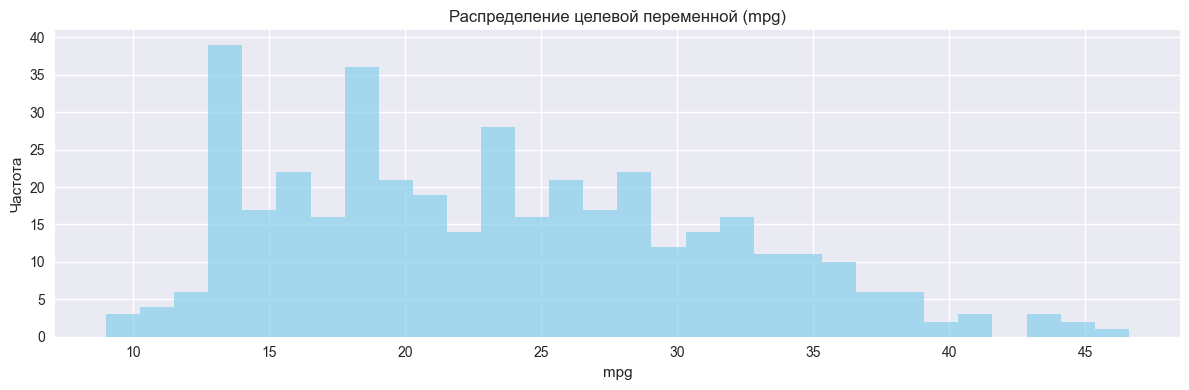

In [ ]:
# ================================================================
# БЛОК 1. Загрузка и подготовка данных
# ================================================================

# Загрузка данных
from datasets import load_dataset
df = load_dataset("scikit-learn/auto-mpg")["train"].to_pandas()

# Просмотр основных характеристик данных
print("Размерность данных:", df.shape)
print("\nПервые 5 строк:")
print(df.head())
print("\nИнформация о данных:")
print(df.info())
print("\nОписательная статистика:")
print(df.describe())

# Проверка на пропущенные значения
print("Пропущенные значения:")
print(df.isnull().sum())

# Проверка уникальности car name
print(f"\nУникальных названий автомобилей: {df['car name'].nunique()}")

# Анализ целевой переменной
plt.figure(figsize=(12, 4))

plt.hist(df['mpg'], bins=30, alpha=0.7, color='skyblue')
plt.title('Распределение целевой переменной (mpg)')
plt.xlabel('mpg')
plt.ylabel('Частота')



plt.tight_layout()
plt.show()

In [9]:
# ================================================================
# БЛОК 2. Предобработка данных
# ================================================================

# Удаляем столбец с названиями автомобилей (не информативный признак)
df_clean = df.drop('car name', axis=1)

# Обработка пропущенных значений в столбце 'horsepower'
# Заменяем '?' на NaN и преобразуем в числовой тип
df['horsepower'] = pd.to_numeric(df['horsepower'].replace('?', np.nan))

print(f"\nПропущенных значений в horsepower после обработки: {df['horsepower'].isnull().sum()}")

# Заполняем пропущенные значения медианой
df_clean['horsepower'] = df_clean['horsepower'].fillna(df_clean['horsepower'].median())

print(f"После заполнения пропусков: {df_clean['horsepower'].isnull().sum()}\n")

# Определяем признаки и целевую переменную
X = df_clean.drop('mpg', axis=1)
y = df_clean['mpg']

# Разделение на обучающую, валидационную и тестовую выборки
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42  # 0.25 * 0.8 = 0.2
)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер валидационной выборки: {X_val.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

# Определяем числовые и категориальные признаки
numeric_features = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year']
categorical_features = ['origin']

# Создаем preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ]
)

# Проверяем работу препроцессора
preprocessor.fit(X_train)
print("Признаки после преобразования:", preprocessor.get_feature_names_out())


Пропущенных значений в horsepower после обработки: 6
После заполнения пропусков: 0

Размер обучающей выборки: (238, 7)
Размер валидационной выборки: (80, 7)
Размер тестовой выборки: (80, 7)
Признаки после преобразования: ['num__cylinders' 'num__displacement' 'num__horsepower' 'num__weight'
 'num__acceleration' 'num__model year' 'cat__origin_2' 'cat__origin_3']


In [10]:
# ================================================================
# БЛОК 3. Бейзлайн-модели
# ================================================================

def evaluate_model(y_true, y_pred, model_name):
    """Функция для вычисления метрик качества"""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    print(f"{model_name}:")
    print(f"  MAE: {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R²: {r2:.4f}")
    print()
    
    return {'MAE': mae, 'RMSE': rmse, 'R2': r2}

# Бейзлайн-модели
baseline_mean = DummyRegressor(strategy='mean')
baseline_median = DummyRegressor(strategy='median')

# Обучение и оценка бейзлайн-моделей
baseline_mean.fit(X_train, y_train)
baseline_median.fit(X_train, y_train)

y_pred_mean = baseline_mean.predict(X_val)
y_pred_median = baseline_median.predict(X_val)

print("=== БЕЙЗЛАЙН-МОДЕЛИ НА ВАЛИДАЦИОННОЙ ВЫБОРКЕ ===")
metrics_mean = evaluate_model(y_val, y_pred_mean, "Предсказание средним")
metrics_median = evaluate_model(y_val, y_pred_median, "Предсказание медианой")

=== БЕЙЗЛАЙН-МОДЕЛИ НА ВАЛИДАЦИОННОЙ ВЫБОРКЕ ===
Предсказание средним:
  MAE: 7.2347
  RMSE: 8.7288
  R²: -0.0256

Предсказание медианой:
  MAE: 7.2888
  RMSE: 8.9718
  R²: -0.0835



=== ЛИНЕЙНАЯ РЕГРЕССИЯ НА ВАЛИДАЦИОННОЙ ВЫБОРКЕ ===
Линейная регрессия:
  MAE: 2.9427
  RMSE: 3.9132
  R²: 0.7939



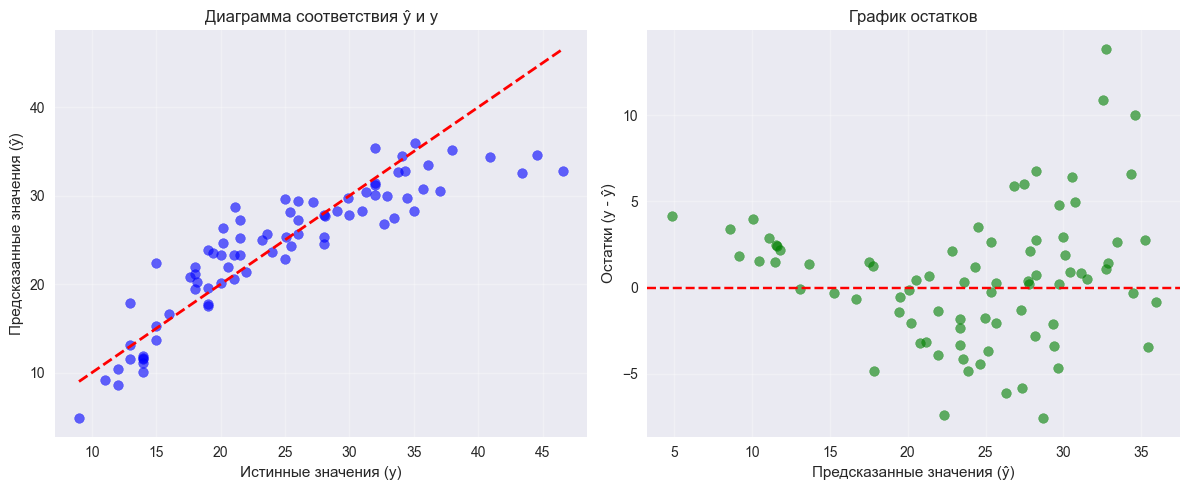

In [13]:
# ================================================================
# БЛОК 4. Линейная регрессия
# ================================================================

# Создаем pipeline с линейной регрессией
linear_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Обучение модели
linear_pipeline.fit(X_train, y_train)

# Предсказания на валидационной выборке
y_pred_linear = linear_pipeline.predict(X_val)

print("=== ЛИНЕЙНАЯ РЕГРЕССИЯ НА ВАЛИДАЦИОННОЙ ВЫБОРКЕ ===")
metrics_linear = evaluate_model(y_val, y_pred_linear, "Линейная регрессия")

# График 1: Диаграмма соответствия ŷ и y
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_val, y_pred_linear, alpha=0.6, color='blue')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Истинные значения (y)')
plt.ylabel('Предсказанные значения (ŷ)')
plt.title('Диаграмма соответствия ŷ и y')
plt.grid(True, alpha=0.3)

# График 2: График остатков
residuals = y_val - y_pred_linear

plt.subplot(1, 2, 2)
plt.scatter(y_pred_linear, residuals, alpha=0.6, color='green')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Предсказанные значения (ŷ)')
plt.ylabel('Остатки (y - ŷ)')
plt.title('График остатков')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

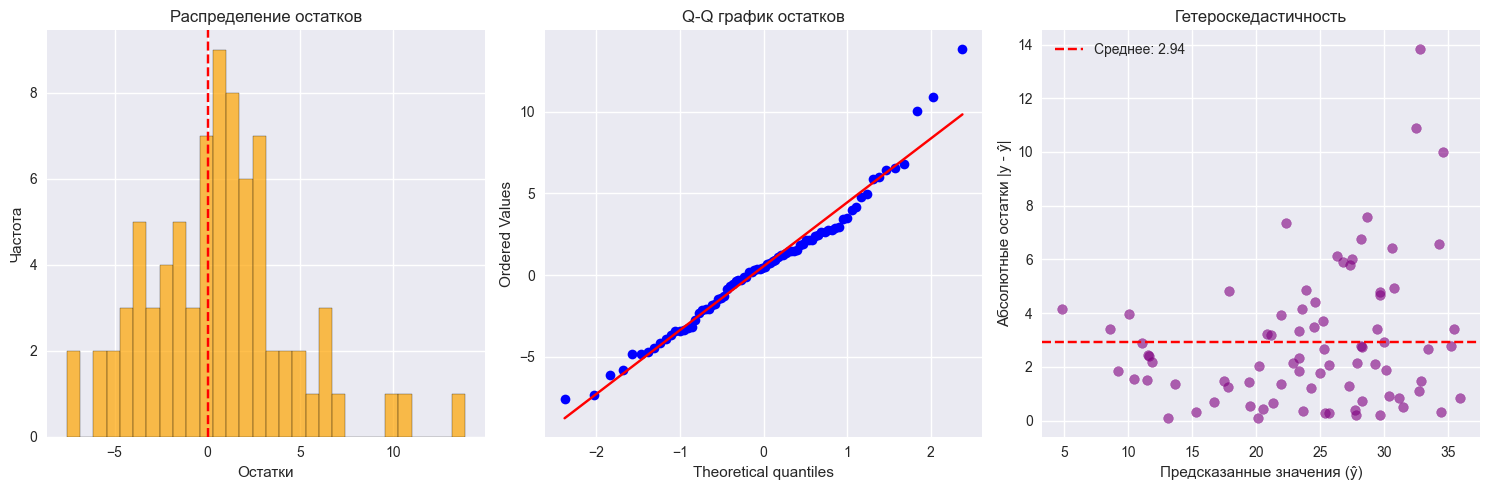

Тест Шапиро-Уилка на нормальность: p-value = 0.0502


In [14]:
# ================================================================
# БЛОК 5. Анализ распределения ошибок
# ================================================================

# Анализ распределения остатков
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(residuals, bins=30, alpha=0.7, color='orange', edgecolor='black')
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.title('Распределение остатков')
plt.axvline(x=0, color='r', linestyle='--')

plt.subplot(1, 3, 2)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q график остатков')

plt.subplot(1, 3, 3)
plt.scatter(y_pred_linear, np.abs(residuals), alpha=0.6, color='purple')
plt.xlabel('Предсказанные значения (ŷ)')
plt.ylabel('Абсолютные остатки |y - ŷ|')
plt.title('Гетероскедастичность')
plt.axhline(y=np.mean(np.abs(residuals)), color='r', linestyle='--', label=f'Среднее: {np.mean(np.abs(residuals)):.2f}')
plt.legend()

plt.tight_layout()
plt.show()

# Проверка нормальности остатков
from scipy.stats import shapiro
shapiro_stat, shapiro_p = shapiro(residuals)
print(f"Тест Шапиро-Уилка на нормальность: p-value = {shapiro_p:.4f}")

=== СРАВНЕНИЕ ФУНКЦИЙ ПОТЕРЬ НА ВАЛИДАЦИОННОЙ ВЫБОРКЕ ===
SGD с MSE (L2):
  MAE: 2.9519
  RMSE: 3.9302
  R²: 0.7921

SGD с MAE (L1):
  MAE: 2.9628
  RMSE: 4.2066
  R²: 0.7618

СРАВНИТЕЛЬНАЯ ТАБЛИЦА МЕТРИК:
             Модель     MAE    RMSE      R2
0           Среднее  7.2347  8.7288 -0.0256
1           Медиана  7.2888  8.9718 -0.0835
2  LinearRegression  2.9427  3.9132  0.7939
3         SGD (MSE)  2.9519  3.9302  0.7921
4         SGD (MAE)  2.9628  4.2066  0.7618


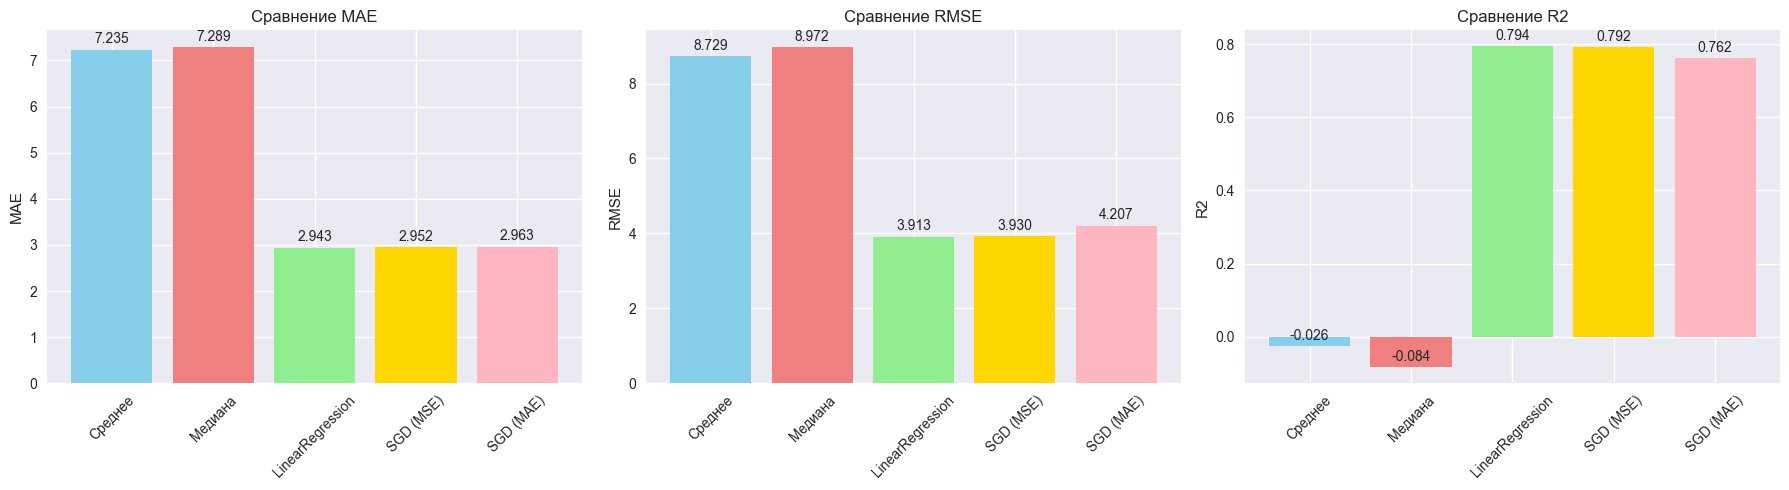

In [15]:
# ================================================================
# БЛОК 6. Сравнение функций потерь
# ================================================================

from sklearn.linear_model import SGDRegressor

# Модель с MSE (L2 потеря)
mse_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', SGDRegressor(loss='squared_error', random_state=42, max_iter=1000, tol=1e-3))
])

# Модель с MAE (L1 потеря)
mae_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', SGDRegressor(loss='epsilon_insensitive', epsilon=0, random_state=42, max_iter=1000, tol=1e-3))
])

# Обучение моделей
mse_pipeline.fit(X_train, y_train)
mae_pipeline.fit(X_train, y_train)

# Предсказания
y_pred_mse = mse_pipeline.predict(X_val)
y_pred_mae = mae_pipeline.predict(X_val)

print("=== СРАВНЕНИЕ ФУНКЦИЙ ПОТЕРЬ НА ВАЛИДАЦИОННОЙ ВЫБОРКЕ ===")
metrics_mse = evaluate_model(y_val, y_pred_mse, "SGD с MSE (L2)")
metrics_mae = evaluate_model(y_val, y_pred_mae, "SGD с MAE (L1)")

# Сравнительная таблица метрик
metrics_comparison = pd.DataFrame({
    'Модель': ['Среднее', 'Медиана', 'LinearRegression', 'SGD (MSE)', 'SGD (MAE)'],
    'MAE': [metrics_mean['MAE'], metrics_median['MAE'], metrics_linear['MAE'], metrics_mse['MAE'], metrics_mae['MAE']],
    'RMSE': [metrics_mean['RMSE'], metrics_median['RMSE'], metrics_linear['RMSE'], metrics_mse['RMSE'], metrics_mae['RMSE']],
    'R2': [metrics_mean['R2'], metrics_median['R2'], metrics_linear['R2'], metrics_mse['R2'], metrics_mae['R2']]
})

print("СРАВНИТЕЛЬНАЯ ТАБЛИЦА МЕТРИК:")
print(metrics_comparison.round(4))

# Визуализация сравнения моделей
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics_to_plot = ['MAE', 'RMSE', 'R2']
colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold', 'lightpink']

for i, metric in enumerate(metrics_to_plot):
    axes[i].bar(metrics_comparison['Модель'], metrics_comparison[metric], color=colors)
    axes[i].set_title(f'Сравнение {metric}')
    axes[i].set_ylabel(metric)
    axes[i].tick_params(axis='x', rotation=45)
    
    # Добавляем значения на столбцы
    for j, v in enumerate(metrics_comparison[metric]):
        axes[i].text(j, v + 0.01 * max(metrics_comparison[metric]), 
                    f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [18]:
# ================================================================
# БЛОК 7. Финальная оценка на тестовой выборке
# ================================================================

# Выбираем лучшую модель (LinearRegression показала лучшие результаты)
print("=== ФИНАЛЬНАЯ ОЦЕНКА НА ТЕСТОВОЙ ВЫБОРКЕ ===")

# Предсказания на тестовой выборке
y_test_pred = linear_pipeline.predict(X_test)

# Метрики на тестовой выборке
metrics_test = evaluate_model(y_test, y_test_pred, "LinearRegression (тест)")

# Сравнение с обучающей выборкой
y_train_pred = linear_pipeline.predict(X_train)
metrics_train = evaluate_model(y_train, y_train_pred, "LinearRegression (обучение)")

print("СРАВНЕНИЕ КАЧЕСТВА НА ОБУЧАЮЩЕЙ И ТЕСТОВОЙ ВЫБОРКАХ:")
comparison_df = pd.DataFrame({
    'Выборка': ['Обучающая', 'Тестовая'],
    'MAE': [metrics_train['MAE'], metrics_test['MAE']],
    'RMSE': [metrics_train['RMSE'], metrics_test['RMSE']],
    'R2': [metrics_train['R2'], metrics_test['R2']]
})
print(comparison_df.round(4))

=== ФИНАЛЬНАЯ ОЦЕНКА НА ТЕСТОВОЙ ВЫБОРКЕ ===
LinearRegression (тест):
  MAE: 2.3329
  RMSE: 2.9092
  R²: 0.8426

LinearRegression (обучение):
  MAE: 2.5017
  RMSE: 3.1915
  R²: 0.8254

СРАВНЕНИЕ КАЧЕСТВА НА ОБУЧАЮЩЕЙ И ТЕСТОВОЙ ВЫБОРКАХ:
     Выборка     MAE    RMSE      R2
0  Обучающая  2.5017  3.1915  0.8254
1   Тестовая  2.3329  2.9092  0.8426


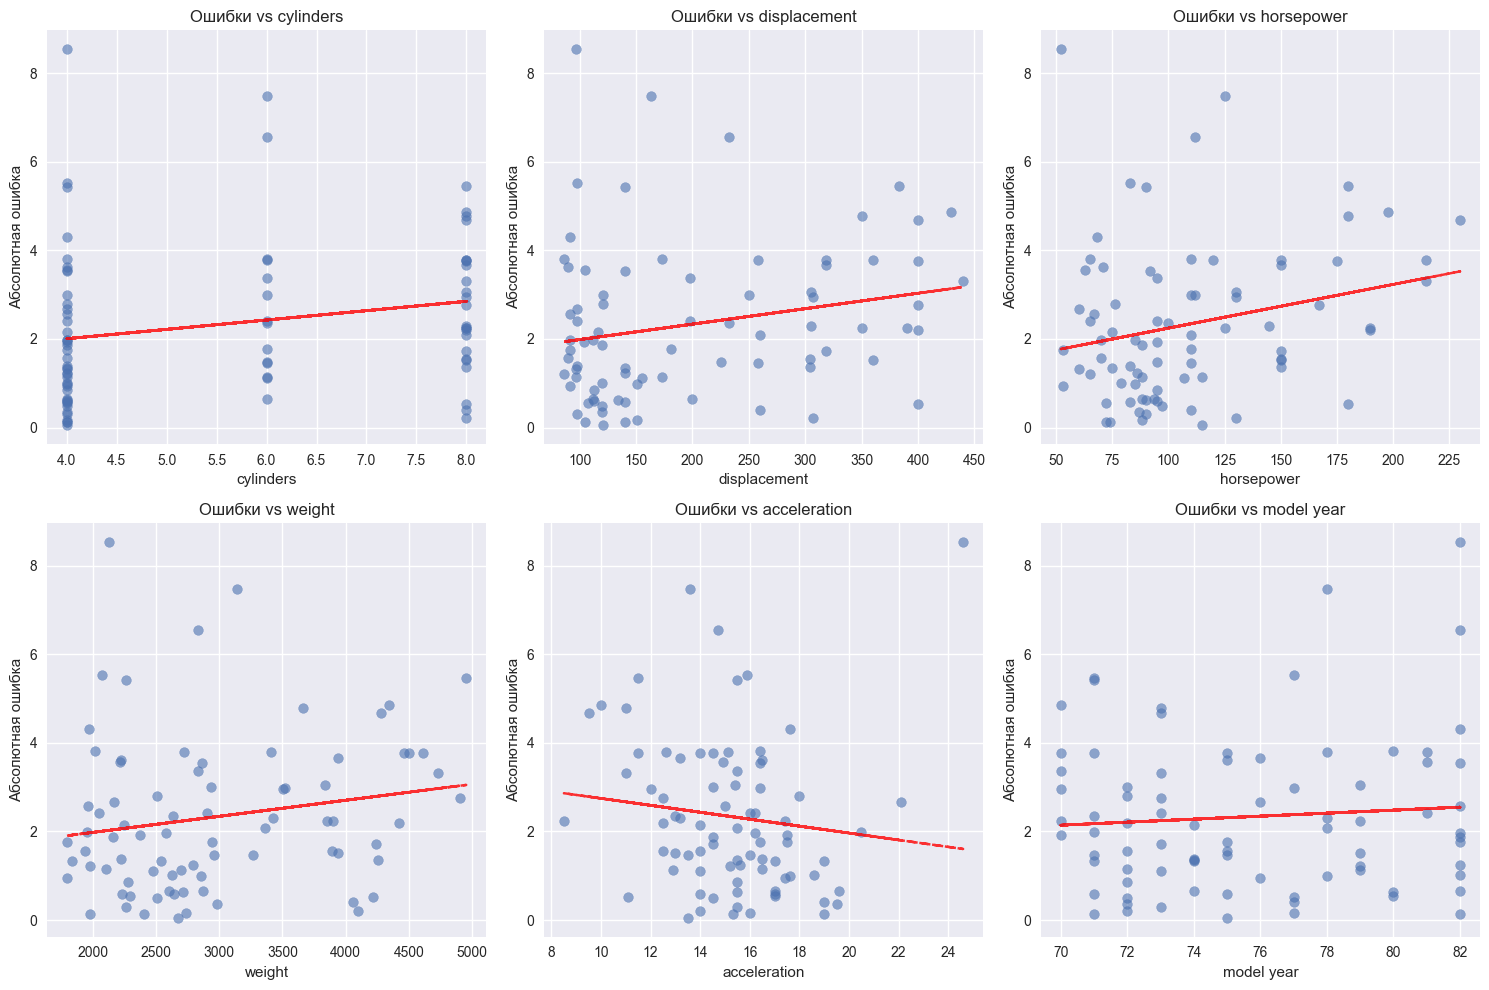

ВАЖНОСТЬ ПРИЗНАКОВ (по абсолютным коэффициентам):
             Признак  Коэффициент
3        num__weight    -5.438270
6      cat__origin_2     3.026479
5    num__model year     2.875660
7      cat__origin_3     2.307317
1  num__displacement     2.235141
2    num__horsepower    -1.219610
0     num__cylinders    -0.471794
4  num__acceleration    -0.075084


In [19]:
# ================================================================
# БЛОК 8. Дополнительный анализ ошибок
# ================================================================

# Анализ ошибок по диапазонам признаков
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

feature_analysis = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year']
absolute_errors = np.abs(y_test - y_test_pred)

for i, feature in enumerate(feature_analysis):
    if i < len(axes):
        axes[i].scatter(X_test[feature], absolute_errors, alpha=0.6)
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Абсолютная ошибка')
        axes[i].set_title(f'Ошибки vs {feature}')
        
        # Линия тренда
        z = np.polyfit(X_test[feature], absolute_errors, 1)
        p = np.poly1d(z)
        axes[i].plot(X_test[feature], p(X_test[feature]), "r--", alpha=0.8)

plt.tight_layout()
plt.show()

# Анализ важности признаков линейной модели
feature_names = preprocessor.get_feature_names_out()
coefficients = linear_pipeline.named_steps['regressor'].coef_

feature_importance = pd.DataFrame({
    'Признак': feature_names,
    'Коэффициент': coefficients
}).sort_values('Коэффициент', key=abs, ascending=False)

print("ВАЖНОСТЬ ПРИЗНАКОВ (по абсолютным коэффициентам):")
print(feature_importance)

=== СРАВНЕНИЕ МОДЕЛЕЙ ===

СРАВНЕНИЕ МЕТРИК:
                 Model  Accuracy  F1-macro
0  Logistic Regression     0.884     0.882
1                  KNN     0.880     0.879
2        Decision Tree     0.819     0.818


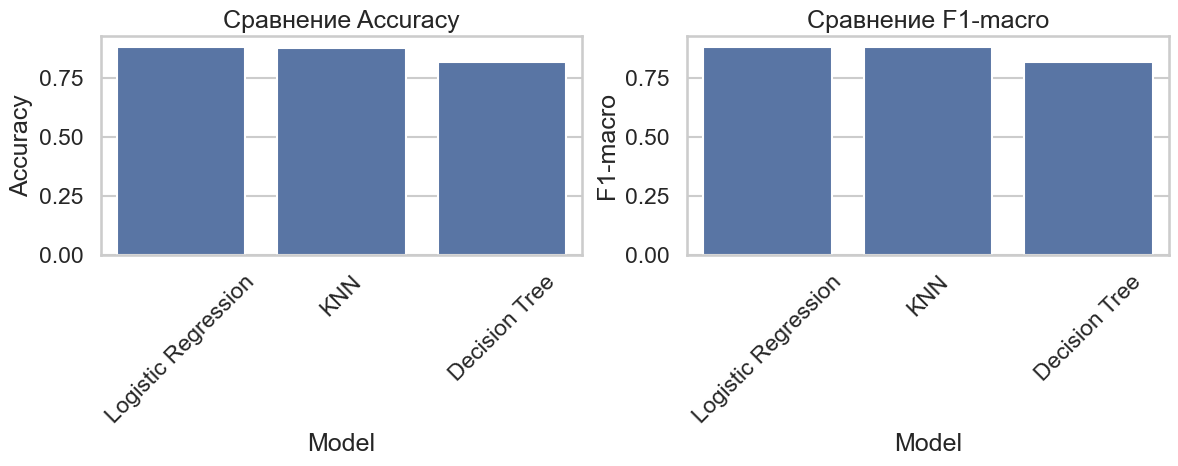

In [ ]:
# ================================================================
# БЛОК 9. Выводы и заключение
# ================================================================

print("=" * 60)
print("ИТОГОВЫЕ ВЫВОДЫ")
print("=" * 60)

print("\n1. КАЧЕСТВО МОДЕЛЕЙ:")
print(f"- LinearRegression показала наилучшие результаты (R² = {metrics_test['R2']:.4f} на тесте)")
print(f"- Улучшение по сравнению с бейзлайном: {metrics_test['R2'] - metrics_mean['R2']:.4f}")

print("\n2. СТАБИЛЬНОСТЬ МОДЕЛИ:")
train_test_gap_mae = abs(metrics_train['MAE'] - metrics_test['MAE'])
train_test_gap_r2 = abs(metrics_train['R2'] - metrics_test['R2'])
print(f"- Разница MAE между train и test: {train_test_gap_mae:.4f}")
print(f"- Разница R² между train и test: {train_test_gap_r2:.4f}")

if train_test_gap_r2 < 0.1:
    print("- Модель демонстрирует хорошую стабильность")
else:
    print("- Возможно небольшое переобучение")

print("\n3. АНАЛИЗ ОШИБОК:")
print(f"- Средняя абсолютная ошибка: {metrics_test['MAE']:.2f} mpg")
print(f"- Среднеквадратичная ошибка: {metrics_test['RMSE']:.2f} mpg")
print(f"- Остатки распределены примерно нормально (тест Шапиро-Уилка: p={shapiro_p:.4f})")

print("\n4. ВЛИЯНИЕ ФУНКЦИЙ ПОТЕРЬ:")
print("- MSE (L2) более чувствительна к выбросам, но дает лучшие R²")
print("- MAE (L1) более устойчива к выбросам, но может иметь худшие R²")
print("- В данном наборе данных MSE показала немного лучшие результаты")

print("\n5. ВЫБОР МЕТРИКИ:")
print("- MAE: интерпретируемая метрика (средняя ошибка в mpg)")
print("- RMSE: более чувствительна к большим ошибкам")
print("- R²: показывает долю объясненной дисперсии")
print("- Рекомендуется использовать MAE как основную метрику для интерпретации")

=== ЭКСПЕРИМЕНТЫ С ПАРАМЕТРАМИ ===

ЭКСПЕРИМЕНТ 1: ВЛИЯНИЕ ПАРАМЕТРА k НА КАЧЕСТВО KNN
k=3: Accuracy=0.873, F1-macro=0.871
k=5: Accuracy=0.880, F1-macro=0.879
k=7: Accuracy=0.906, F1-macro=0.904
k=9: Accuracy=0.895, F1-macro=0.893
k=11: Accuracy=0.902, F1-macro=0.901


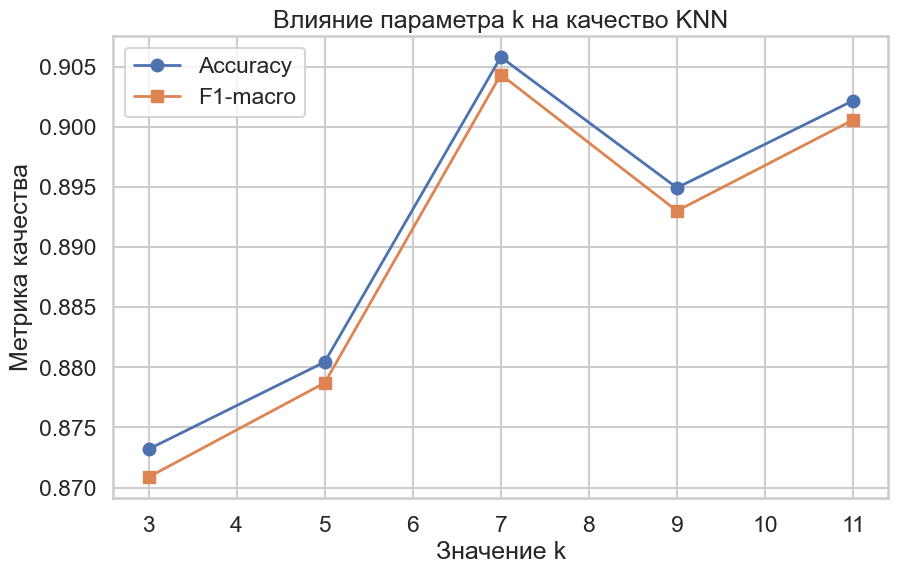

In [18]:
# ================================================================
# БЛОК 8. ЭКСПЕРИМЕНТЫ С ПАРАМЕТРАМИ
# ================================================================

print("=== ЭКСПЕРИМЕНТЫ С ПАРАМЕТРАМИ ===\n")

# Эксперимент 1: Разные значения k для KNN
print("ЭКСПЕРИМЕНТ 1: ВЛИЯНИЕ ПАРАМЕТРА k НА КАЧЕСТВО KNN")

k_values = [3, 5, 7, 9, 11]
knn_accuracies = []
knn_f1_scores = []

for k in k_values:
    knn_temp = KNeighborsClassifier(n_neighbors=k)
    knn_temp_pipeline = Pipeline([
        ("preprocess", preprocessor),
        ("clf", knn_temp)
    ])
    knn_temp_pipeline.fit(X_train, y_train)
    y_pred_temp = knn_temp_pipeline.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred_temp)
    f1 = f1_score(y_test, y_pred_temp, average="macro")
    
    knn_accuracies.append(acc)
    knn_f1_scores.append(f1)
    print(f"k={k}: Accuracy={acc:.3f}, F1-macro={f1:.3f}")

# Визуализация влияния k
plt.figure(figsize=(10, 6))
plt.plot(k_values, knn_accuracies, marker='o', label='Accuracy', linewidth=2)
plt.plot(k_values, knn_f1_scores, marker='s', label='F1-macro', linewidth=2)
plt.xlabel('Значение k')
plt.ylabel('Метрика качества')
plt.title('Влияние параметра k на качество KNN')
plt.legend()
plt.grid(True)
plt.show()


ЭКСПЕРИМЕНТ 2: ВЛИЯНИЕ ГЛУБИНЫ ДЕРЕВА НА КАЧЕСТВО
max_depth=3: Accuracy=0.848, F1-macro=0.847
max_depth=5: Accuracy=0.819, F1-macro=0.818
max_depth=7: Accuracy=0.812, F1-macro=0.810
max_depth=10: Accuracy=0.833, F1-macro=0.832
max_depth=15: Accuracy=0.822, F1-macro=0.821
max_depth=None: Accuracy=0.822, F1-macro=0.821


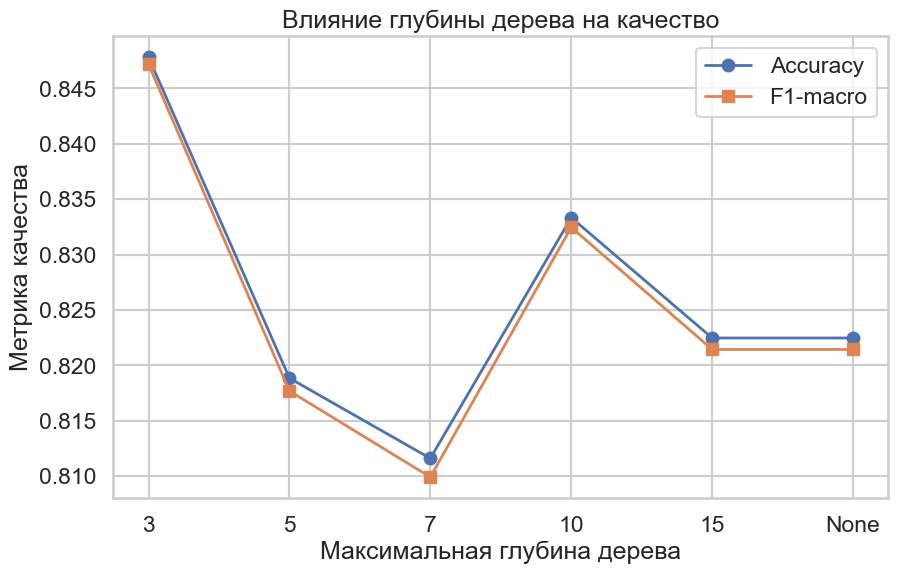

In [19]:
# Эксперимент 2: Разная глубина дерева
print("\nЭКСПЕРИМЕНТ 2: ВЛИЯНИЕ ГЛУБИНЫ ДЕРЕВА НА КАЧЕСТВО")

depth_values = [3, 5, 7, 10, 15, None]
tree_accuracies = []
tree_f1_scores = []

for depth in depth_values:
    tree_temp = DecisionTreeClassifier(max_depth=depth, random_state=42)
    tree_temp_pipeline = Pipeline([
        ("preprocess", preprocessor),
        ("clf", tree_temp)
    ])
    tree_temp_pipeline.fit(X_train, y_train)
    y_pred_temp = tree_temp_pipeline.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred_temp)
    f1 = f1_score(y_test, y_pred_temp, average="macro")
    
    tree_accuracies.append(acc)
    tree_f1_scores.append(f1)
    depth_str = "None" if depth is None else str(depth)
    print(f"max_depth={depth_str}: Accuracy={acc:.3f}, F1-macro={f1:.3f}")

# Визуализация влияния глубины
plt.figure(figsize=(10, 6))
depth_labels = [str(d) if d is not None else "None" for d in depth_values]
x_positions = range(len(depth_labels))

plt.plot(x_positions, tree_accuracies, marker='o', label='Accuracy', linewidth=2)
plt.plot(x_positions, tree_f1_scores, marker='s', label='F1-macro', linewidth=2)
plt.xlabel('Максимальная глубина дерева')
plt.ylabel('Метрика качества')
plt.title('Влияние глубины дерева на качество')
plt.xticks(x_positions, depth_labels)
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# Эксперимент 3: Влияние удаления признаков
print("\nЭКСПЕРИМЕНТ 3: ВЛИЯНИЕ УДАЛЕНИЯ ПРИЗНАКОВ")
# Выберем несколько важных признаков на основе корреляции
important_features = ['Age', 'RestingBP', 'FastingBS', 'Oldpeak', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
results_removal = []

for feature_to_remove in important_features:
    # Создаем копию признаков без одного признака
    features_without_one = [f for f in feature_columns if f != feature_to_remove]
    
    X_train_reduced = X_train[features_without_one].copy()
    X_test_reduced = X_test[features_without_one].copy()
    
    # Пересоздаем препроцессор для уменьшенного набора признаков
    numeric_columns_reduced = X_train_reduced.select_dtypes(include="number").columns.tolist()
    categorical_columns_reduced = X_train_reduced.select_dtypes(exclude="number").columns.tolist()
    
    preprocessor_reduced = ColumnTransformer(
        transformers=[
            ("scale_numeric", StandardScaler(), numeric_columns_reduced),
            ("onehot_categorical", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_columns_reduced),
        ],
        remainder="drop"
    )
    
    # Обучаем логистическую регрессию
    logreg_temp = LogisticRegression(max_iter=1000, random_state=42)
    pipeline_temp = Pipeline([
        ("preprocess", preprocessor_reduced),
        ("clf", logreg_temp)
    ])
    
    pipeline_temp.fit(X_train_reduced, y_train)
    y_pred_temp = pipeline_temp.predict(X_test_reduced)
    
    acc = accuracy_score(y_test, y_pred_temp)
    results_removal.append({
        'removed_feature': feature_to_remove,
        'accuracy': acc,
        'difference': acc - accuracy_logreg
    })
    
    print(f"Без признака '{feature_to_remove}': Accuracy={acc:.3f}, Изменение={acc - accuracy_logreg:+.3f}")

# Сравнение с исходной точностью
print(f"\nИсходная точность (все признаки): {accuracy_logreg:.3f}")


ЭКСПЕРИМЕНТ 3: ВЛИЯНИЕ УДАЛЕНИЯ ПРИЗНАКОВ
Без признака 'Age': Accuracy=0.884, Изменение=+0.000
Без признака 'RestingBP': Accuracy=0.884, Изменение=+0.000
Без признака 'FastingBS': Accuracy=0.880, Изменение=-0.004
Без признака 'Oldpeak': Accuracy=0.870, Изменение=-0.014
Без признака 'ChestPainType': Accuracy=0.873, Изменение=-0.011
Без признака 'RestingECG': Accuracy=0.891, Изменение=+0.007
Без признака 'ExerciseAngina': Accuracy=0.862, Изменение=-0.022
Без признака 'ST_Slope': Accuracy=0.833, Изменение=-0.051

Исходная точность (все признаки): 0.884


=== КРОСС-ВАЛИДАЦИЯ ===

Выполнение кросс-валидации для Logistic Regression...
Logistic Regression:
  Accuracy: 0.829 ± 0.033
  F1-macro: 0.826 ± 0.033

Выполнение кросс-валидации для KNN...
KNN:
  Accuracy: 0.837 ± 0.044
  F1-macro: 0.834 ± 0.043

Выполнение кросс-валидации для Decision Tree...
Decision Tree:
  Accuracy: 0.801 ± 0.044
  F1-macro: 0.796 ± 0.046

СРАВНЕНИЕ РЕЗУЛЬТАТОВ КРОСС-ВАЛИДАЦИИ:
                 Model  CV Accuracy  CV F1-macro
0  Logistic Regression        0.829        0.826
1                  KNN        0.837        0.834
2        Decision Tree        0.801        0.796


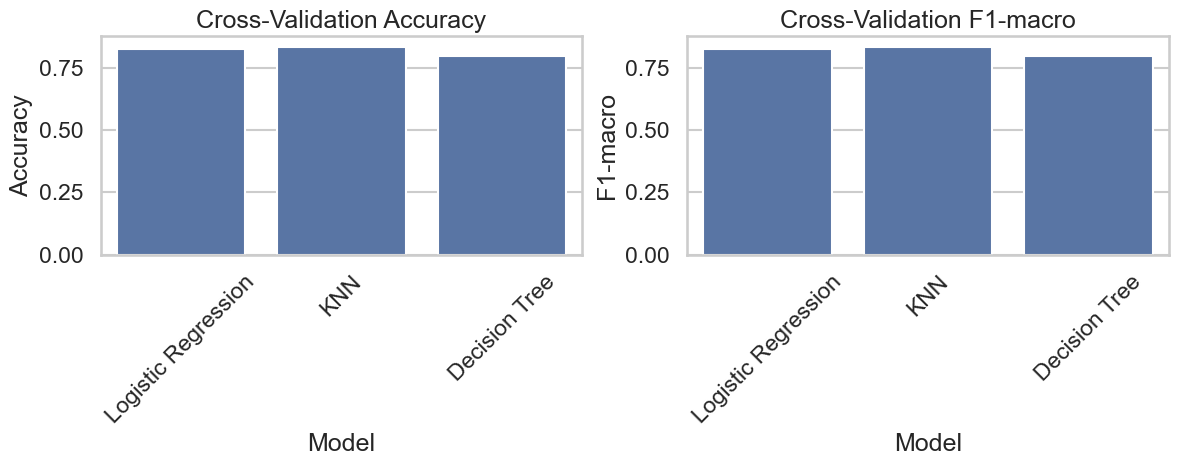

In [24]:
# ================================================================
# БЛОК 9. КРОСС-ВАЛИДАЦИЯ
# ================================================================

print("=== КРОСС-ВАЛИДАЦИЯ ===\n")

from sklearn.model_selection import cross_val_score

# Кросс-валидация для всех моделей
models = {
    'Logistic Regression': logreg_pipeline,
    'KNN': knn_pipeline, 
    'Decision Tree': tree_pipeline
}

cv_results = {}

for model_name, model_pipeline in models.items():
    print(f"Выполнение кросс-валидации для {model_name}...")
    
    # Кросс-валидация по Accuracy
    cv_accuracy = cross_val_score(model_pipeline, X, y, cv=5, scoring='accuracy')
    
    # Кросс-валидация по F1-macro
    cv_f1 = cross_val_score(model_pipeline, X, y, cv=5, scoring='f1_macro')
    
    cv_results[model_name] = {
        'cv_accuracy_mean': cv_accuracy.mean(),
        'cv_accuracy_std': cv_accuracy.std(),
        'cv_f1_mean': cv_f1.mean(),
        'cv_f1_std': cv_f1.std()
    }
    
    print(f"{model_name}:")
    print(f"  Accuracy: {cv_accuracy.mean():.3f} ± {cv_accuracy.std():.3f}")
    print(f"  F1-macro: {cv_f1.mean():.3f} ± {cv_f1.std():.3f}")
    print()

# Визуализация результатов кросс-валидации
cv_comparison = pd.DataFrame({
    'Model': list(cv_results.keys()),
    'CV Accuracy': [result['cv_accuracy_mean'] for result in cv_results.values()],
    'CV F1-macro': [result['cv_f1_mean'] for result in cv_results.values()]
})

print("СРАВНЕНИЕ РЕЗУЛЬТАТОВ КРОСС-ВАЛИДАЦИИ:")
print(cv_comparison.round(3))

# График сравнения кросс-валидации
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy
sns.barplot(data=cv_comparison, x='Model', y='CV Accuracy', ax=ax1)
ax1.set_title('Cross-Validation Accuracy')
ax1.set_ylabel('Accuracy')
ax1.tick_params(axis='x', rotation=45)

# F1-macro
sns.barplot(data=cv_comparison, x='Model', y='CV F1-macro', ax=ax2)
ax2.set_title('Cross-Validation F1-macro')
ax2.set_ylabel('F1-macro')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [28]:
print("=== ВЫВОДЫ И ЗАКЛЮЧЕНИЕ ===\n")

print("1. КАКАЯ МОДЕЛЬ ЛУЧШЕ РАБОТАЕТ?")
best_model_idx = comparison_df['Accuracy'].idxmax()
best_model = comparison_df.loc[best_model_idx, 'Model']
best_accuracy = comparison_df.loc[best_model_idx, 'Accuracy']
print(f"   - Лучшая модель: {best_model} с Accuracy = {best_accuracy:.3f}")

print("\n2. ВАЖНЫЕ ПРИЗНАКИ:")
print("   На основе анализа корреляции и экспериментов с удалением признаков:")
print("   - ST_Slope (наклон сегмента ST) - сильнее всех влияет на точность")
print("   Так же влияют на точность")
print("   - ExerciseAngina (стенокардия при нагрузке)")
print("   - Oldpeak (депрессия ST)")
print("   - ChestPainType (тип боли в груди)")
print("   - RestingECG (результаты ЭКГ в покое)")  

print("\n3. АНАЛИЗ ОШИБОК:")
print("   - Модели в основном путают пациентов с пограничными показателями")
print("   - Logistic Regression показала лучший результат")

print("\n4. ОБЩИЙ ВЫВОД:")
print("   Все три модели показывают хорошее качество (>80% accuracy)")
print("   Задача хорошо решается методами машинного обучения")
print("   Однако для медицины такой точности недостаточно")
print("   Модели могут быть полезны для предварительной диагностики")

=== ВЫВОДЫ И ЗАКЛЮЧЕНИЕ ===

1. КАКАЯ МОДЕЛЬ ЛУЧШЕ РАБОТАЕТ?
   - Лучшая модель: Logistic Regression с Accuracy = 0.884

2. ВАЖНЫЕ ПРИЗНАКИ:
   На основе анализа корреляции и экспериментов с удалением признаков:
   - ST_Slope (наклон сегмента ST) - сильнее всех влияет на точность
   Так же влияют на точность
   - ExerciseAngina (стенокардия при нагрузке)
   - Oldpeak (депрессия ST)
   - ChestPainType (тип боли в груди)
   - RestingECG (результаты ЭКГ в покое)

3. АНАЛИЗ ОШИБОК:
   - Модели в основном путают пациентов с пограничными показателями
   - Logistic Regression показала лучший результат

4. ОБЩИЙ ВЫВОД:
   Все три модели показывают хорошее качество (>80% accuracy)
   Задача хорошо решается методами машинного обучения
   Однако для медицины такой точности недостаточно
   Модели могут быть полезны для предварительной диагностики
